In [363]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


#Put your file path here

path = 'C:/Users/MaxBo/OneDrive/Documents/Green Flag Digital/GenZ Tariffs'


os.chdir(path)

In [365]:
#import skeleton of final dataset

import pandas as pd

genz = pd.read_csv('GenZ_Tariffs2.csv')

In [64]:
#List of the columns from google sheets dataset

genz.columns

Index(['FIPS', 'Area Name (short)', 'Area Name (long)', 'Area Type',
       'Tarriff Impact', 'Industry Diversity', 'City economic growth',
       'AI growth cities', 'F 500 cities', 'Job listings growth',
       'Entry-Level Job Density', 'Cost of living - raw',
       'Cost of living divided by salary', 'Fun factor* (multi-faceted)'],
      dtype='object')

## Variable: Tariff Impact


#### Source
Brookings Study

#### Variables in Play
Each top 100 city has three target variables from the brookings study that explain how much they are affected
by resilience. Share of exports under retaliation, share of direct export jobs under retaliaton, and share of share of total export jobs under retaliation. 

#### Method
We will use these variables as the score for our tariff impact category. Either a weighted average or normal average, depending
on the correlation, will be used to combine these three target variables. Then, I will invert the variables since our overarching ranking is to find the best cities for GenZ. So low economic resilience is expressed by high share of export under retaliation. Then normalization from 0 to 10 to set us up for final category rankings. 

In [65]:
#import tariff data

tariff = pd.read_csv('TariffData.csv')

In [66]:
tariff.columns

Index(['Rank by Area Type', 'FIPS', 'Area Name (short)', 'Area Name (long)',
       'Area Type', 'Total Exports (mil.)', 'Direct Export-supported jobs',
       'Total Export-supported jobs', 'Total Exports under retaliation (mil.)',
       'Direct Export-supported jobs under retaliation',
       'Total Export-supported jobs under retaliation',
       'Share of Exports under retaliation',
       'Share of Direct Export-supported jobs under retaliation',
       'Share of Total Export-supported jobs under retaliation'],
      dtype='object')

In [67]:
#Take a look

tariff.head(2)

,Rank by Area Type,FIPS,Area Name (short),Area Name (long),Area Type,Total Exports (mil.),Direct Export-supported jobs,Total Export-supported jobs,Total Exports under retaliation (mil.),Direct Export-supported jobs under retaliation,Total Export-supported jobs under retaliation,Share of Exports under retaliation,Share of Direct Export-supported jobs under retaliation,Share of Total Export-supported jobs under retaliation
0,1,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,"3,924.10","13,389","22,909",552,"2,346","3,678",14.10%,17.50%,16.10%
1,2,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,"4,120.40","16,986","29,989",557.8,"2,415","4,043",13.50%,14.20%,13.50%


In [68]:
print(tariff.dtypes)

Rank by Area Type                                           int64
FIPS                                                        int64
Area Name (short)                                          object
Area Name (long)                                           object
Area Type                                                  object
Total Exports (mil.)                                       object
Direct Export-supported jobs                               object
Total Export-supported jobs                                object
Total Exports under retaliation (mil.)                     object
Direct Export-supported jobs under retaliation             object
Total Export-supported jobs under retaliation              object
Share of Exports under retaliation                         object
Share of Direct Export-supported jobs under retaliation    object
Share of Total Export-supported jobs under retaliation     object
dtype: object


In [69]:
#Convert to numerical datatype

tariff['Share of Exports under retaliation_int'] = tariff['Share of Exports under retaliation'].str.rstrip('%').astype(float)

tariff['Share of Direct Export-supported jobs under retaliation_int'] = tariff['Share of Direct Export-supported jobs under retaliation'].str.rstrip('%').astype(float)

tariff['Share of Total Export-supported jobs under retaliation_int'] = tariff['Share of Total Export-supported jobs under retaliation'].str.rstrip('%').astype(float)

In [70]:
#Our target variables that capture tariff effect regardless of city size are the last three variables
#We will normalize each percentage from 0 to 1. 

for col in ['Share of Exports under retaliation_int',
            'Share of Direct Export-supported jobs under retaliation_int',
            'Share of Total Export-supported jobs under retaliation_int']:
    tariff[col + '_norm'] = (tariff[col] - tariff[col].min()) / (tariff[col].max() - tariff[col].min())


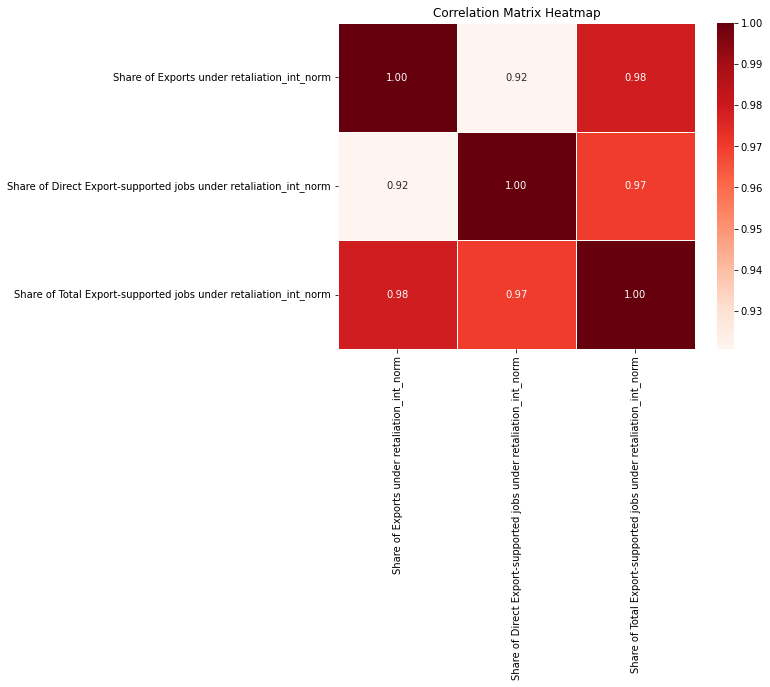

                                                    Share of Exports under retaliation_int_norm  \
Share of Exports under retaliation_int_norm                                            1.000000   
Share of Direct Export-supported jobs under ret...                                     0.920679   
Share of Total Export-supported jobs under reta...                                     0.978773   

                                                    Share of Direct Export-supported jobs under retaliation_int_norm  \
Share of Exports under retaliation_int_norm                                                  0.920679                  
Share of Direct Export-supported jobs under ret...                                           1.000000                  
Share of Total Export-supported jobs under reta...                                           0.970111                  

                                                    Share of Total Export-supported jobs under retaliation_int_norm  
Shar

In [71]:
#Correlation matrix to observe relationships between target variables

tariff_targets = tariff.iloc[:, -3:]

correlation_matrix = tariff_targets.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

print(correlation_matrix)

In [72]:
#All are very correlated (above .9) as expected. We do not need to combine these variables with weights. We can just take the mean. 
#Averaging these three will potentially smooth out some noise.

tariff['tariff_impact'] = tariff[['Share of Exports under retaliation_int_norm',
        'Share of Direct Export-supported jobs under retaliation_int_norm',
        'Share of Total Export-supported jobs under retaliation_int_norm']].mean(axis=1)




In [73]:
#High tariff impact means the city is worse off under retaliation and therefore lack resilience.
#Invert impact score 

tariff['tariff_impact_score_inv'] = 1 - tariff['tariff_impact']

In [74]:
#Normalize from 0 to 10 to create our final ranking for this variable that will be used in the econ. resilience category

tariff['tariff_impact_score'] = (
    (tariff['tariff_impact_score_inv'] - tariff['tariff_impact_score_inv'].min()) /
    (tariff['tariff_impact_score_inv'].max() - tariff['tariff_impact_score_inv'].min())
) * 10

In [75]:
#Cut down table... 

tariff_final = tariff[['FIPS', 'tariff_impact_score']]



In [76]:
#and merge to our final dataset

#Make sure we have matching data types for our FIPS id
genz['FIPS'] = genz['FIPS'].astype(str)
tariff_final['FIPS'] = tariff_final['FIPS'].astype(str)

#Merge
genz = genz.merge(tariff_final, on='FIPS', how='left')


C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/157402272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_final['FIPS'] = tariff_final['FIPS'].astype(str)


In [77]:
#Assign to correctly named variable

genz['Tarriff Impact'] = genz['tariff_impact_score']

In [79]:
#Remove duplicate
genz = genz.drop(columns=['tariff_impact_score'])

In [80]:
#Take a look
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted)
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#Check missing values just in case.

missing = genz[genz['Tarriff Impact'].isnull()]
len(missing)

#We are good. Move on to next variable. 

0

## Variable: Industry Diversity

#### Source

https://www.chmura.com/blog/chmura-economic-diversity

This dataset shows economic diversity index by Metropolitan Statistical Area (MSA)

Chmura uses a third statistic which compares the economic diversity of a region to the national level. Specifically, this index measures the industry employment mix of a region in comparison to that of the United States-the United States being the most economically diverse region with an index value of 0.00. For a comparison region, **a relatively low index value implies that the region is fairly economically diverse**, while a high value means the region is not very economically diverse.


#### Variables in Play
We have 2021, 2016, and 2011 data. We will use 2021 data.


#### Method
Merge our econ diversity data to our top 100 cities. Then inverse the index since a low index means higher industry diversity. Normalize from 0-10.

In [84]:
#Load in data

econ_diversity = pd.read_csv('IndustryDiversity.csv')

In [85]:
#Take a look

econ_diversity.head(3)

,region_description,diversity_index_2021,diversity_index_2016,diversity_index_2011
0,"Hanford-Corcoran, CA MSA",106.78,104.28,102.47
1,"Elkhart-Goshen, IN MSA",105.71,99.54,93.49
2,"Hinesville, GA MSA",100.12,98.18,99.48


In [86]:
#Length?

len(econ_diversity)

384

In [88]:
#We have all metropolitan areas but we only need our top 100 from our final dataset.
#Let's try a merge

#First extract our 100 cities
target_cities = genz[['Area Name (short)', 'Area Name (long)']]

In [106]:
target_cities.head(5)

,Area Name (short),Area Name (long)
0,"Bakersfield, CA","Bakersfield, CA"
1,"Fresno, CA","Fresno, CA"
2,"Stockton, CA","Stockton-Lodi, CA"
3,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC"
4,"Birmingham, AL","Birmingham-Hoover, AL"


In [101]:
#All cities here have ' MSA' at the end of their name. Get rid of this for merge. 

econ_diversity['Area Name (long)'] = econ_diversity['region_description'].str.replace(r' MSA$', '', regex=True)


In [107]:
econ_diversity.head(5)

,region_description,diversity_index_2021,diversity_index_2016,diversity_index_2011,Area Name (long)
0,"Hanford-Corcoran, CA MSA",106.78,104.28,102.47,"Hanford-Corcoran, CA"
1,"Elkhart-Goshen, IN MSA",105.71,99.54,93.49,"Elkhart-Goshen, IN"
2,"Hinesville, GA MSA",100.12,98.18,99.48,"Hinesville, GA"
3,"El Centro, CA MSA",99.85,98.69,98.19,"El Centro, CA"
4,"Madera, CA MSA",98.70,99.94,101.72,"Madera, CA"


In [104]:
#Merge our Area names with the (long) one as id

econ_diversity_100 = target_cities.merge(econ_diversity, on='Area Name (long)', how='left')

In [110]:
#See how many nulls we got from this

sum(econ_diversity_100['diversity_index_2021'].isnull())

17

In [111]:
#17 Nulls, most likely due to the fact that we have two different area name styles. 
#Fix by using (short) as ID

econ_diversity['Area Name (short)'] = econ_diversity['region_description'].str.replace(r' MSA$', '', regex=True)

In [113]:
econ_diversity_100 = econ_diversity_100.merge(econ_diversity, on='Area Name (short)', how='left')

In [115]:
#Keep columns we need, our index will be in both 2021 x and y columns

econ_diversity_100.columns

Index(['Area Name (short)', 'Area Name (long)_x', 'region_description_x',
       'diversity_index_2021_x', 'diversity_index_2016_x',
       'diversity_index_2011_x', 'region_description_y',
       'diversity_index_2021_y', 'diversity_index_2016_y',
       'diversity_index_2011_y', 'Area Name (long)_y'],
      dtype='object')

In [116]:
#Cut down columns

econ_diversity_100 = econ_diversity_100[['Area Name (short)', 'Area Name (long)_x','diversity_index_2021_x','diversity_index_2021_y']]

In [118]:
#As expected we have mismatches due to area names being mixed (long and short) in the MSA data set
econ_diversity_100.head()

,Area Name (short),Area Name (long)_x,diversity_index_2021_x,diversity_index_2021_y
0,"Bakersfield, CA","Bakersfield, CA",75.10,75.10
1,"Fresno, CA","Fresno, CA",60.62,60.62
2,"Stockton, CA","Stockton-Lodi, CA",NaN,68.48
3,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",48.32,NaN
4,"Birmingham, AL","Birmingham-Hoover, AL",47.30,NaN


In [120]:
#Use combine first function to fix mismatches
econ_diversity_100['diversity_index_2021'] = econ_diversity_100['diversity_index_2021_x'].combine_first(econ_diversity_100['diversity_index_2021_y'])


C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/3047578419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_diversity_100['diversity_index_2021'] = econ_diversity_100['diversity_index_2021_x'].combine_first(econ_diversity_100['diversity_index_2021_y'])


In [122]:
#We still have 16 nulls which means the data name is different than our final dataset name. 

sum(econ_diversity_100['diversity_index_2021'].isnull())

16

In [128]:
#See what cities are missing

econ_diversity_missing = pd.isnull(econ_diversity_100["diversity_index_2021"])
print(econ_diversity_100[econ_diversity_missing])

    Area Name (short)                            Area Name (long)_x  \
6       Nashville, TN  Nashville-Davidson-Murfreesboro-Franklin, TN   
16       Scranton, PA            Scranton-Wilkes-Barre-Hazleton, PA   
19      Milwaukee, WI             Milwaukee-Waukesha-West Allis, WI   
33     Greenville, SC               Greenville-Anderson-Mauldin, SC   
44   Grand Rapids, MI                      Grand Rapids-Wyoming, MI   
60     Sacramento, CA         Sacramento-Roseville-Arden-Arcade, CA   
61        Buffalo, NY         Buffalo-Cheektowaga-Niagara Falls, NY   
67         Dayton, OH                                    Dayton, OH   
69        Raleigh, NC                                   Raleigh, NC   
70       Hartford, CT      Hartford-West Hartford-East Hartford, CT   
71        Phoenix, AZ                   Phoenix-Mesa-Scottsdale, AZ   
78      San Diego, CA                        San Diego-Carlsbad, CA   
80        Atlanta, GA             Atlanta-Sandy Springs-Roswell, GA   
86    

In [129]:
#After looking through why this data is not merging properly, I see that the hyphens in the MSA data are sometimes
#double hyphens. Also, some long names in our original dataset do not match with names in MSA data. 

#In a dataset with thousands of missing values, I would use more data engineering methods to fix this. But to ensure accuracy,
#I can export to CSV and manually enter our 16 missing values due to the small sizes of our datasets.

econ_diversity_100.to_csv("econ_diversity_100.csv", index=False)

In [131]:
#load in data

econ_diversity_100 = pd.read_csv('econ_diversity_100.csv')

In [136]:
#Should have zero nulls in this column now

sum(econ_diversity_100['diversity_index_2021'].isnull())

0

In [138]:
#Brilliant, now we cut down to what we need. An area name and our 2021 diversity index

econ_diversity_100 = econ_diversity_100[['Area Name (long)_x','diversity_index_2021']]

In [140]:
#Take a look

econ_diversity_100.head(5)

,Area Name (long)_x,diversity_index_2021
0,"Bakersfield, CA",75.10
1,"Fresno, CA",60.62
2,"Stockton-Lodi, CA",68.48
3,"Virginia Beach-Norfolk-Newport News, VA-NC",48.32
4,"Birmingham-Hoover, AL",47.30


In [141]:
#Rename our columns

econ_diversity_100.rename(columns={'Area Name (long)_x': 'Area Name (long)', 'diversity_index_2021': 'Industry Diversity'}, inplace=True)

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/2109717324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_diversity_100.rename(columns={'Area Name (long)_x': 'Area Name (long)', 'diversity_index_2021': 'Industry Diversity'}, inplace=True)


In [143]:
#Ok remember this index is inverted with high indexes meaning LESS economic diversity
#Invert index and then normalize 0-10 to finish off this variable

econ_diversity_100['industry_diversity_inverted'] = econ_diversity_100['Industry Diversity'].max() - econ_diversity_100['Industry Diversity']


C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/3314257023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_diversity_100['industry_diversity_inverted'] = econ_diversity_100['Industry Diversity'].max() - econ_diversity_100['Industry Diversity']


In [148]:
#Take a look at our min and max 

econ_diversity_100['Industry Diversity'].describe()

count    100.000000
mean      48.262400
std        8.841803
min       31.420000
25%       41.690000
50%       46.645000
75%       53.202500
max       75.100000
Name: Industry Diversity, dtype: float64

In [152]:
#Normalize from 0 to 10 to create our final ranking for this variable that will be used in the econ. resilience category

econ_diversity_100['industry_diversity_score'] = (
    (econ_diversity_100['industry_diversity_inverted'] - econ_diversity_100['industry_diversity_inverted'].min()) /
    (econ_diversity_100['industry_diversity_inverted'].max() - econ_diversity_100['industry_diversity_inverted'].min())
) * 10

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/2978093616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_diversity_100['industry_diversity_score'] = (


In [156]:
#Cut down to what we need for merge

econ_diversity_100 = econ_diversity_100[['Area Name (long)','industry_diversity_score']]

In [161]:
#Merge to our final dataset

genz = genz.merge(econ_diversity_100, on='Area Name (long)', how='left')

In [163]:
pd.set_option('display.max_columns', None)
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),industry_diversity_score
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.315018
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.515568


In [165]:
#Assign to correctly named variable
genz['Industry Diversity'] = genz['industry_diversity_score']

In [167]:
#Remove duplicate
genz = genz.drop(columns=['industry_diversity_score'])

In [168]:
#Take a look
genz.head()

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted)
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47260,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",Top 100 metro areas,5.422980,6.130952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13820,"Birmingham, AL","Birmingham-Hoover, AL",Top 100 metro areas,5.380786,6.364469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
#Check missing values just in case.

missing = genz[genz['Industry Diversity'].isnull()]
len(missing)

#We are good. Move on to next variable. 

0

## Variable:City Economic Growth

#### Source

https://apps.bea.gov/itable/?ReqID=70&step=1#eyJhcHBpZCI6NzAsInN0ZXBzIjpbMSwyOSwyNSwzMSwyNiwyNywzMF0sImRhdGEiOltbIlRhYmxlSWQiLCI1MzMiXSxbIk1ham9yX0FyZWEiLCI1Il0sWyJTdGF0ZSIsWyI1Il1dLFsiQXJlYSIsWyJYWCJdXSxbIlN0YXRpc3RpYyIsWyItMSJdXSxbIlVuaXRfb2ZfbWVhc3VyZSIsIlBlcmNlbnRDaGFuZ2UiXSxbIlllYXIiLFsiMjAyMyJdXSxbIlllYXJCZWdpbiIsIi0xIl0sWyJZZWFyX0VuZCIsIi0xIl1dfQ==

U.S. Bureau of Economic Analysis (BEA). Metropolitan Statistical Area percent change growth in GDP 2022-2023


#### Variables in Play

We are looking at percent change from 2022-2023 in Real GDP (chained 2017 dollars) which is inflation adjusted

#### Method

Cut down to our top 100 cities and normalize percent changes from 0 to 10


In [182]:
#Load in data

city_growth = pd.read_csv('CityEconGrowth.csv')

In [183]:
#Take a look

city_growth

,GeoFips,GeoName,LineCode,Description,2023
0,998,United States (Metropolitan Portion),1,Real GDP (thousands of chained 2017 dollars),2.7
1,998,United States (Metropolitan Portion),2,Chain-type quantity indexes for real GDP,2.7
2,998,United States (Metropolitan Portion),3,Current-dollar GDP (thousands of current dollars),6.9
3,10180,"Abilene, TX (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),3.3
...,...,...,...,...,...
1151,49700,"Yuba City, CA (Metropolitan Statistical Area)",3,Current-dollar GDP (thousands of current dollars),5.5
1152,49740,"Yuma, AZ (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),3.4
1153,49740,"Yuma, AZ (Metropolitan Statistical Area)",2,Chain-type quantity indexes for real GDP,3.4
1154,49740,"Yuma, AZ (Metropolitan Statistical Area)",3,Current-dollar GDP (thousands of current dollars),6.8


In [184]:
#We want the real GDP in chained 2017 dollars which is line code == 1

city_growth = city_growth[city_growth['LineCode']==1]

In [185]:
city_growth.reset_index()

,index,GeoFips,GeoName,LineCode,Description,2023
0,0,998,United States (Metropolitan Portion),1,Real GDP (thousands of chained 2017 dollars),2.7
1,3,10180,"Abilene, TX (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),3.3
2,6,10420,"Akron, OH (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),1.1
3,9,10500,"Albany, GA (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),1.0
...,...,...,...,...,...,...
381,1143,49620,"York-Hanover, PA (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),3.1
382,1146,49660,"Youngstown-Warren-Boardman, OH-PA (Metropolita...",1,Real GDP (thousands of chained 2017 dollars),2.0
383,1149,49700,"Yuba City, CA (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),2.1
384,1152,49740,"Yuma, AZ (Metropolitan Statistical Area)",1,Real GDP (thousands of chained 2017 dollars),3.4


In [186]:
#Check missing values just in case.

missing = city_growth[city_growth['2023'].isnull()]
len(missing)

0

In [187]:
#Extract the FIPS our top 100 cities

fips_100 = genz['FIPS']

In [190]:
#Convert from series to dataframe

fips_100 = fips_100.to_frame()

In [192]:
#Rename FIPS column to match

city_growth.rename(columns={'GeoFips': 'FIPS'}, inplace=True)

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/325796713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_growth.rename(columns={'GeoFips': 'FIPS'}, inplace=True)


In [195]:
#Ensure both are same datatype for our merge

fips_100['FIPS'] = fips_100['FIPS'].astype(str)
city_growth['FIPS'] = city_growth['FIPS'].astype(str)

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/39067424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_growth['FIPS'] = city_growth['FIPS'].astype(str)


In [196]:
#Merge to just keep our 100 cities

city_econ_growth_100 = fips_100.merge(city_growth, on='FIPS', how='left')

In [198]:
#Check nulls

sum(city_econ_growth_100['2023'].isnull())

1

In [199]:
#1 Null, see what it is

city_growth_missing = pd.isnull(city_econ_growth_100["2023"])
print(city_econ_growth_100[city_growth_missing])

     FIPS GeoName  LineCode Description  2023
67  19380     NaN       NaN         NaN   NaN


In [200]:
#19380 is Dayton, Ohio. They have different FIPS in our data set. We can export and manually fix once again.

city_econ_growth_100.to_csv("city_econ_growth_100.csv", index=False)

In [201]:
#Import

city_econ_growth_100 = pd.read_csv('city_econ_growth_100.csv')

In [202]:
#Check nulls

sum(city_econ_growth_100['2023'].isnull())

0

In [203]:
#Check length
len(city_econ_growth_100)

100

In [204]:
#Percent change normalization from 0-10

city_econ_growth_100['City economic growth'] = (
    (city_econ_growth_100['2023'] - city_econ_growth_100['2023'].min()) /
    (city_econ_growth_100['2023'].max() - city_econ_growth_100['2023'].min())
) * 10

In [206]:
#See summary stats of our normalization

city_econ_growth_100['City economic growth'].describe()

count    100.000000
mean       4.456000
std        2.034334
min        0.000000
25%        2.933333
50%        4.200000
75%        5.766667
max       10.000000
Name: City economic growth, dtype: float64

In [208]:
#Cut down columns we dont need

city_econ_growth_100 = city_econ_growth_100[['FIPS','City economic growth']]

In [211]:
#Merge to our final dataset

city_econ_growth_100['FIPS'] = city_econ_growth_100['FIPS'].astype(str)
genz['FIPS'] = genz['FIPS'].astype(str)

genz = genz.merge(city_econ_growth_100, on='FIPS', how='left')

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/1658032263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_econ_growth_100['FIPS'] = city_econ_growth_100['FIPS'].astype(str)


In [212]:
pd.set_option('display.max_columns', None)
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth_x,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),City economic growth_y
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733333
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.200000
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [213]:
genz['City economic growth_x'] = genz['City economic growth_y']

In [215]:
#Remove duplicate
genz = genz.drop(columns=['City economic growth_y'])

In [216]:
#Rename

genz.rename(columns={'City economic growth_x': 'City economic growth'}, inplace=True)

In [217]:
#Take a look
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted)
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
#Check missing values just in case.

missing = genz[genz['City economic growth'].isnull()]
len(missing)

#We are good. Move on to next variable. 

0

In [219]:
#Save progress

genz.to_csv("genz_save.csv", index=False)

## Variable: AI Growth

#### Source

https://www.chmura.com/blog/the-state-of-ai-jobs-and-talent

This dataset is a supply and demand analysis of AI jobs. This will show which cities are the best for AI jobs.
Not just simply which city has the most AI jobs. This dataset **adjusts** for the job market difficulty.

#### Variables in Play

Two variables are important here. 

1. Resume to Job Ad Ratio: Supply/demand variable. Low means less supply of AI labor and high is more supply. Over 1 exceeds demand.
2. Active Job Ads: How many AI jobs ads there are.


#### Method

First get data only for our 100 target cities. Next, transform first variable to have high value mean better opportunity for AI jobs. Then, adjust this using the active job ads variable. A city might have a good ratio but a low amount of jobs. We should penalize this since it wont be helpful to new grads. Then normalize this 0 to 10 and use for the first variable in our career growth category.


In [221]:
#Load in data

AI = pd.read_csv('AI_Industry_Analysis.csv')

In [223]:
#Take a look

AI.head()

,Location,Resume to Job Ad Ratio,Latitude (generated),Longitude (generated),Active Job Ads
0,"Yuma, AZ MSA",0.222222,32.7522,-113.9364,9
1,"Yuba City, CA MSA",0.142857,39.1868,-121.6103,7
2,"Youngstown-Warren, OH MSA",1.363636,41.0470,-80.7607,11
3,"York-Hanover, PA MSA",0.209524,39.9731,-76.7431,105
4,"Yakima, WA MSA",0.285714,46.5645,-120.6486,7


In [225]:
#Merge to our target 100 cities

#First remove MSA at the end of city names

AI['Area Name (long)'] = AI['Location'].str.replace(r' MSA$', '', regex=True)

In [228]:
#Merge on long names first

AI_100 = target_cities.merge(AI, on='Area Name (long)', how='left')

In [231]:
#Merge on short names 
#duplicate
AI['Area Name (short)'] = AI['Area Name (long)']

In [234]:
AI_100 = AI_100.merge(AI, on='Area Name (short)', how='left')

In [236]:
AI_100.columns

Index(['Area Name (short)', 'Area Name (long)_x', 'Location_x',
       'Resume to Job Ad Ratio_x', 'Latitude (generated)_x',
       'Longitude (generated)_x', 'Active Job Ads_x', 'Location_y',
       'Resume to Job Ad Ratio_y', 'Latitude (generated)_y',
       'Longitude (generated)_y', 'Active Job Ads_y', 'Area Name (long)_y'],
      dtype='object')

In [237]:
#Keep what we need

AI_100 = AI_100[['Area Name (short)','Area Name (long)_x','Resume to Job Ad Ratio_x','Active Job Ads_x',
                'Resume to Job Ad Ratio_y','Active Job Ads_y']]

In [239]:
#Use combine first function to fix mismatches

AI_100['Resume to Job Ad Ratio'] = AI_100['Resume to Job Ad Ratio_x'].combine_first(AI_100['Resume to Job Ad Ratio_y'])

AI_100['Active Job Ads'] = AI_100['Active Job Ads_x'].combine_first(AI_100['Active Job Ads_y'])

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/553377822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AI_100['Resume to Job Ad Ratio'] = AI_100['Resume to Job Ad Ratio_x'].combine_first(AI_100['Resume to Job Ad Ratio_y'])
C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/553377822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AI_100['Active Job Ads'] = AI_100['Active Job Ads_x'].combine_first(AI_100['Active Job Ads_y'])


In [244]:
#Remove x and y columns

AI_100 = AI_100[['Area Name (short)','Area Name (long)_x','Resume to Job Ad Ratio','Active Job Ads']]

In [248]:
#How many missing after merging

print(sum(AI_100['Resume to Job Ad Ratio'].isnull()))

print(sum(AI_100['Active Job Ads'].isnull()))

29
29


In [249]:
#Like earlier some of the location names did not match the short or long versions. 
#We will manually enter their data.

AI_100.to_csv("AI_100.csv", index=False)

In [335]:
#Import

AI_100 = pd.read_csv('AI_100.csv')

In [336]:
#Do we have missing values

missing = AI_100[AI_100['Resume to Job Ad Ratio'].isnull()]
len(missing)

0

In [337]:
AI_100.head(2)

,Area Name (short),Area Name (long)_x,Resume to Job Ad Ratio,Active Job Ads
0,"Bakersfield, CA","Bakersfield, CA",0.419753,81
1,"Fresno, CA","Fresno, CA",0.282609,92


In [338]:
#Nope, now onto transformations

#First we must invert Resume to job ad. We want high to mean more opportunity. Less resumes, more job ads. Less supply, more demand


AI_100['Resume to Job Ad Ratio_inv'] = 1 / AI_100['Resume to Job Ad Ratio']

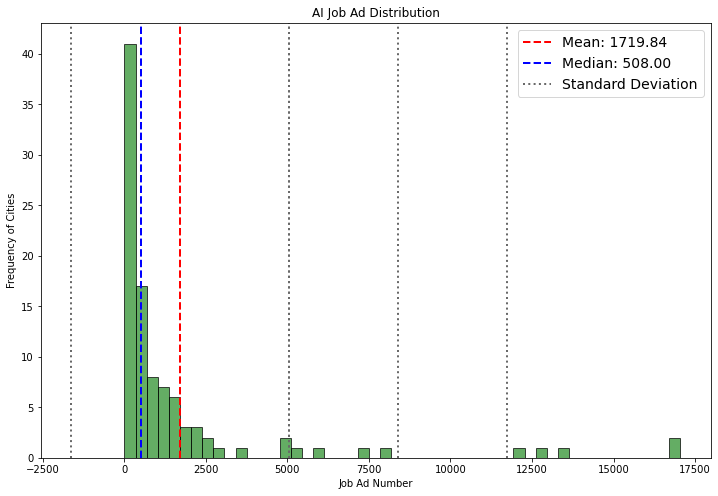

In [339]:
mean_value = AI_100['Active Job Ads'].mean()
median_value = AI_100['Active Job Ads'].median()

std_dev = AI_100['Active Job Ads'].std()  # Standard deviation

# Plot histogram for the 'values' column
plt.figure(figsize=(12, 8))
plt.hist(AI_100['Active Job Ads'], bins=50, edgecolor='black', alpha=0.7,color='forestgreen')

#Standard deviation lines along with mean and median lines

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.axvline(mean_value - std_dev, color='dimgray', linestyle='dotted', linewidth=2)  # -1σ
for i in range(1, 4):
    plt.axvline(mean_value + i * std_dev, color='dimgray', linestyle='dotted', linewidth=2)  # +1σ, +2σ, +3σ

plt.axvline(mean_value + std_dev, color='dimgray', linestyle='dotted', linewidth=2, label='Standard Deviation')

plt.xlabel('Job Ad Number')
plt.ylabel('Frequency of Cities')
plt.title('AI Job Ad Distribution')
plt.legend(fontsize=14)

#plt.savefig('Tree Canopy Distribution.jpg', format='jpg')

plt.show()

In [340]:
#Big right skew in our data and a lot of outliers. We should perform a log transformation here.

In [341]:
AI_100['log_job_ads'] = np.log1p(AI_100['Active Job Ads'])

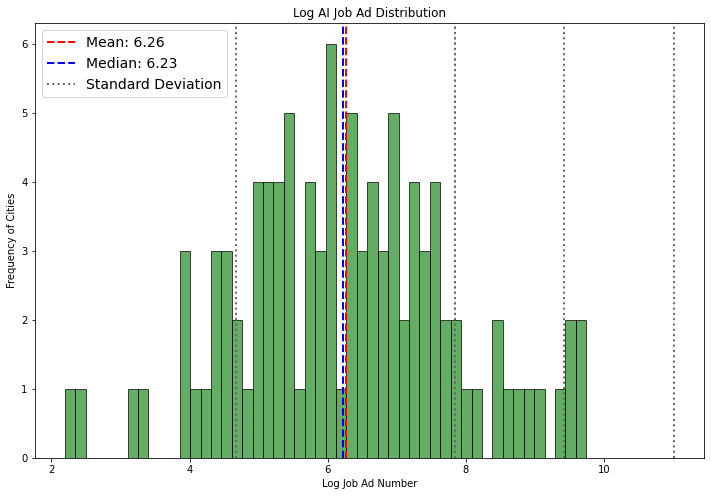

In [342]:
mean_value = AI_100['log_job_ads'].mean()
median_value = AI_100['log_job_ads'].median()

std_dev = AI_100['log_job_ads'].std()  # Standard deviation

# Plot histogram for the 'values' column
plt.figure(figsize=(12, 8))
plt.hist(AI_100['log_job_ads'], bins=50, edgecolor='black', alpha=0.7,color='forestgreen')

#Standard deviation lines along with mean and median lines

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.axvline(mean_value - std_dev, color='dimgray', linestyle='dotted', linewidth=2)  # -1σ
for i in range(1, 4):
    plt.axvline(mean_value + i * std_dev, color='dimgray', linestyle='dotted', linewidth=2)  # +1σ, +2σ, +3σ

plt.axvline(mean_value + std_dev, color='dimgray', linestyle='dotted', linewidth=2, label='Standard Deviation')

plt.xlabel('Log Job Ad Number')
plt.ylabel('Frequency of Cities')
plt.title('Log AI Job Ad Distribution')
plt.legend(fontsize=14)

#plt.savefig('Tree Canopy Distribution.jpg', format='jpg')

plt.show()

In [343]:
#We are about to combine these variables. So we need to normalize first.

AI_100['Ratio_norm'] = (
    (AI_100['Resume to Job Ad Ratio_inv'] - AI_100['Resume to Job Ad Ratio_inv'].min()) /
    (AI_100['Resume to Job Ad Ratio_inv'].max() - AI_100['Resume to Job Ad Ratio_inv'].min())
) * 10

In [344]:
#Now for log job ads

AI_100['log_job_ads_norm'] = (
    (AI_100['log_job_ads'] - AI_100['log_job_ads'].min()) /
    (AI_100['log_job_ads'].max() - AI_100['log_job_ads'].min())
) * 10

In [345]:
#Lets assign a heigher weight to log job ads since I believe the size of the AI industry is more important than the supply demand.

AI_100['ai_growth_score'] = 0.4 * AI_100['Ratio_norm'] + 0.6 * AI_100['log_job_ads_norm']

In [346]:
AI_100.sort_values(by='ai_growth_score',ascending=False).head(8)

,Area Name (short),Area Name (long)_x,Resume to Job Ad Ratio,Active Job Ads,Resume to Job Ad Ratio_inv,log_job_ads,Ratio_norm,log_job_ads_norm,ai_growth_score
96,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",0.373096,16934,2.680279,9.737138,2.563772,9.991887,7.020641
32,"Little Rock, AR","Little Rock-North Little Rock-Conway, AR",0.109244,595,9.153846,6.390241,9.185611,5.556581,7.008193
10,"Augusta, GA-SC","Augusta-Richmond County, GA-SC",0.100503,199,9.950000,5.298317,10.000000,4.109566,6.465739
59,"Oklahoma City, OK","Oklahoma City, OK",0.153565,1094,6.511905,6.998510,6.483158,6.362659,6.410859
95,"New York, NY-NJ-PA","New York-Newark-Jersey City, NY-NJ-PA",0.858845,17038,1.164355,9.743260,1.013127,10.000000,6.405251
64,"Dallas, TX","Dallas-Fort Worth-Arlington, TX",0.369184,7178,2.708679,8.878915,2.592823,8.854571,6.349872
75,"San Jose, CA","San Jose-Sunnyvale-Santa Clara, CA",0.663994,11973,1.506038,9.390493,1.362636,9.532513,6.264562
99,"Urban Honolulu, HI","Urban Honolulu, HI",0.137763,617,7.258824,6.426488,7.247184,5.604617,6.261644


In [347]:
#Normalize one more time

AI_100['ai_growth_score_norm'] = (
    (AI_100['ai_growth_score'] - AI_100['ai_growth_score'].min()) /
    (AI_100['ai_growth_score'].max() - AI_100['ai_growth_score'].min())
) * 10

In [348]:
#solid summary stats

AI_100['ai_growth_score_norm'].describe()

count    100.000000
mean       5.824429
std        2.039760
min        0.000000
25%        4.345952
50%        6.046665
75%        7.324921
max       10.000000
Name: ai_growth_score_norm, dtype: float64

In [349]:
#Ok merge to our final dataset. First rename long column

#Rename our columns

AI_100.rename(columns={'Area Name (long)_x': 'Area Name (long)'}, inplace=True)

In [350]:
#Keep what we need

AI_100 = AI_100[['Area Name (long)','ai_growth_score_norm']]

In [351]:
#Merge on area name


genz = genz.merge(AI_100, on='Area Name (long)', how='left')

In [352]:
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),ai_growth_score_norm_x,ai_growth_score_norm_y
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,NaN,NaN,NaN,NaN,NaN,NaN,3.789428,3.789428
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,NaN,NaN,NaN,NaN,NaN,NaN,4.605771,4.605771
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


In [354]:
#Remove duplicate
genz = genz.drop(columns=['ai_growth_score_norm_x','ai_growth_score_norm_y'])

In [356]:
#Check missing values just in case.

missing = genz[genz['AI growth cities'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [359]:
#Save progress

genz.to_csv("genz_save.csv", index=False)

## Variable: F 500 Cities

#### Source

https://www.50pros.com/fortune500

2025 Dataset for F 500 companies with location included

https://rowzero.io/workbook/A58A99FF92B5B225C3EFC14B/169

Zip Code, MSA, and population data

#### Variables in Play

Has genreal info about each company. Location is what we want.


#### Method

Group by each city and create a count of how many F500 companies are in the city. Then **adjust** it by population. It will be total F500 companies in the city per 100000 residents.
Normalize after completed.

In [491]:
#Load in data

F500 = pd.read_csv("F500 Cities.csv", encoding='ISO-8859-1')


In [492]:
#Columns

F500.columns

Index(['Rank', 'Company', 'Industry', 'City', 'State', 'Zip', 'Website',
       'Employees', 'Revenue', 'Valuation', 'Profits', 'Ticker', 'CEO'],
      dtype='object')

In [493]:
#Create new dataframe that groups by zip code and counts F500 companies
#tried grouping by city but city variable in orignal data source is incorrect

F500_count = F500.groupby('Zip').size().reset_index(name='F500_Count')

In [494]:
F500_count.head(2)

,Zip,F500_Count
0,1104,1
1,1111,1


In [495]:
#Import our zip code dataset

zip1 = pd.read_csv("ZipCodes2.csv",encoding='ISO-8859-1')

In [496]:
#Extract cities
zip1 = zip1[['Name (CSBA)','ZIP','Total Metro Residents']]

In [497]:
#Rename our columns

zip1.rename(columns={'ZIP': 'Zip'}, inplace=True)

In [498]:
#Merge
F500_merge = F500_count.merge(zip1, on='Zip', how='left')

In [499]:
#Group by city and sum F500 counts, and take first instance of population

F500_grouped = F500_merge.groupby('Name (CSBA)').agg({
    'F500_Count': 'sum',
    'Total Metro Residents': 'first'
}).reset_index()



In [500]:
F500_grouped

,Name (CSBA),F500_Count,Total Metro Residents
0,"Akron, OH",3,698398.0
1,"Albert Lea, MN",1,30515.0
2,"Allentown-Bethlehem-Easton, PA-NJ",2,873555.0
3,"Atlanta-Sandy Springs-Roswell, GA",16,6307261.0
...,...,...,...
98,"Washington-Arlington-Alexandria, DC-VA-MD-WV",19,6304975.0
99,"Winona, MN",1,49721.0
100,"Wooster, OH",1,116510.0
101,"Worcester, MA",2,866866.0


In [501]:
#Create F_500 variable adjusted for population size

F500_grouped['F500_per_100k'] = (F500_grouped['F500_Count'] / F500_grouped['Total Metro Residents']) * 100000


In [502]:
#Use our previous method of merging with target cities

#Rename our columns

F500_grouped.rename(columns={'Name (CSBA)': 'Area Name (long)'}, inplace=True)

In [503]:
#Merge our Area names with the (long) one as id

F500_merge2 = target_cities.merge(F500_grouped, on='Area Name (long)', how='left')

In [504]:
F500_merge2

,Area Name (short),Area Name (long),F500_Count,Total Metro Residents,F500_per_100k
0,"Bakersfield, CA","Bakersfield, CA",NaN,NaN,NaN
1,"Fresno, CA","Fresno, CA",NaN,NaN,NaN
2,"Stockton, CA","Stockton-Lodi, CA",NaN,NaN,NaN
3,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",NaN,NaN,NaN
...,...,...,...,...,...
96,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",19.0,6304975.0,0.301349
97,"Miami, FL","Miami-Fort Lauderdale-West Palm Beach, FL",11.0,6183199.0,0.177901
98,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",NaN,NaN,NaN
99,"Urban Honolulu, HI","Urban Honolulu, HI",NaN,NaN,NaN


In [505]:
#Rename our columns

F500_grouped.rename(columns={'Area Name (long)': 'Area Name (short)'}, inplace=True)

In [506]:
#Merge our Area names with the (short) one as id

F500_merge2 = target_cities.merge(F500_merge2, on='Area Name (short)', how='left')

In [509]:
#55 Cities either do not have F500 company or error in merge. Will scrutinize in excel.

sum(F500_merge2['F500_Count'].isnull())

55

In [510]:
#Export to fill out errors and missing values
F500_merge2.to_csv("F500_merge2.csv", index=False)

In [511]:
F500_grouped.to_csv("F500_grouped.csv", index=False)

In [512]:
#import

F500 = pd.read_csv("F500_merge2.csv")

In [515]:
#Check nulls
sum(F500['F500_per_100k'].isnull())

0

In [516]:
F500

,Area Name (short),Area Name (long)_x,Area Name (long)_y,F500_Count,Total Metro Residents,F500_per_100k
0,"Akron, OH","Akron, OH","Akron, OH",3,698398,0.429554
1,"Albany, NY","Albany-Schenectady-Troy, NY","Albany-Schenectady-Troy, NY",0,0,0.000000
2,"Albuquerque, NM","Albuquerque, NM","Albuquerque, NM",0,0,0.000000
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",2,873555,0.228950
...,...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS","Wichita, KS",0,0,0.000000
97,"Winston, NC","Winston-Salem, NC","Winston-Salem, NC",0,0,0.000000
98,"Worcester, MA-CT","Worcester, MA-CT","Worcester, MA-CT",2,866866,0.230716
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA","Youngstown-Warren-Boardman, OH-PA",0,0,0.000000


In [517]:
#Normalize from 0 to 10 to create our final ranking for this variable that will be used in the career growth category

F500['F500_Score'] = (
    (F500['F500_per_100k'] - F500['F500_per_100k'].min()) /
    (F500['F500_per_100k'].max() - F500['F500_per_100k'].min())
) * 10

In [519]:
#Highly skewed due to half our dataset having zero F500 companies

F500['F500_Score'].describe()

count    100.000000
mean       1.555412
std        1.748658
min        0.000000
25%        0.000000
50%        1.180796
75%        2.437823
max       10.000000
Name: F500_Score, dtype: float64

In [521]:
#Extract what we want
F500 = F500[['Area Name (long)_x','F500_Score']]

In [522]:
#rename

#Rename our columns

F500.rename(columns={'Area Name (long)_x': 'Area Name (long)'}, inplace=True)

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/2314440895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F500.rename(columns={'Area Name (long)_x': 'Area Name (long)'}, inplace=True)


In [525]:
#import genz save

genz = pd.read_csv("genz_save.csv")

In [526]:
#merge with final dataset

genz = genz.merge(F500, on='Area Name (long)', how='left')

In [529]:
#assign to correct variable
genz['F 500 cities'] = genz['F500_Score']

In [531]:
#Drop duplicate
genz = genz.drop(columns=['F500_Score'])

In [533]:
#Check missing values just in case.

missing = genz[genz['F 500 cities'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [534]:
#Save progress

genz.to_csv("genz_save.csv", index=False)

## Variable: Job Growth

#### Source

https://www.stewart.com/en/insights/2022/msa-job-growth-10-year-5-year-and-1-year-performance-plus-other-metrics-for-june-2022-data


#### Variables in Play

The variable we want is the 2 year CES job percent change. This goes from Feb 2020 and June 2022.


#### Method
Find 2 year job growth for each MSA. Then attach to target cities and adjust for population. This is done by multiplying growth by city to see how many jobs were added. Then dividing by 1000 for a intepretable value. "How many new jobs per 1000 people?" 
Then normalize for our final score.


In [570]:
job = pd.read_csv("JobListGrowth2.csv", encoding='ISO-8859-1')

job

,Metropolitan Statistical Area,State,Growth
0,Anniston-Oxford,Alabama,-0.019
1,Auburn-Opelika,Alabama,0.024
2,Birmingham - Hoover,Alabama,0.005
3,Daphne-Fairhope-Foley,Alabama,-0.013
...,...,...,...
376,Sheboygan,Wisconsin,-0.029
377,Wausau,Wisconsin,-0.011
378,Casper,Wyoming,-0.045
379,Cheyenne,Wyoming,-0.010


In [571]:
print(job.dtypes)

Metropolitan Statistical Area     object
State                             object
Growth                           float64
dtype: object


In [573]:
#Lets add population to our target citied dataset.

pop = zip1.groupby('Name (CSBA)')['Total Metro Residents'].first().reset_index()

In [575]:
#Rename our columns

pop.rename(columns={'Name (CSBA)': 'Area Name (short)'}, inplace=True)

In [578]:
#Merge
target_cities = target_cities.merge(pop,on='Area Name (short)', how='left')

In [582]:
#rename
pop.rename(columns={'Area Name (short)': 'Area Name (long)'}, inplace=True)

In [583]:
#merge again on long
target_cities = target_cities.merge(pop,on='Area Name (long)', how='left')

In [585]:
#Use combine first function to fix mismatches
target_cities['pop'] = target_cities['Total Metro Residents_x'].combine_first(target_cities['Total Metro Residents_y'])


In [587]:
sum(target_cities['pop'].isnull())

29

In [589]:
#export to edit

target_cities.to_csv("target_cities.csv", index=False)
pop.to_csv("pop.csv", index=False)

In [590]:
#import target cities now with population

target_cities = pd.read_csv("target_cities.csv")

In [593]:
job

,Metropolitan Statistical Area,State,Growth
0,Anniston-Oxford,Alabama,-0.019
1,Auburn-Opelika,Alabama,0.024
2,Birmingham - Hoover,Alabama,0.005
3,Daphne-Fairhope-Foley,Alabama,-0.013
...,...,...,...
376,Sheboygan,Wisconsin,-0.029
377,Wausau,Wisconsin,-0.011
378,Casper,Wyoming,-0.045
379,Cheyenne,Wyoming,-0.010


In [612]:
#Check for cities with same name

duplicates = job[job.duplicated(subset='Metropolitan Statistical Area', keep=False)]
pd.set_option('display.max_rows', None)
duplicates

,Metropolitan Statistical Area,State,Growth
4,Decatur,Alabama,-0.003
70,Gainesville,Florida,0.005
72,Jacksonville,Florida,0.039
89,Albany,Georgia,-0.017
94,Columbus,GA-AL,-0.009
96,Gainesville,Georgia,0.022
110,Bloomington,Illinois,0.005
115,Decatur,Illinois,-0.036
119,Springfield,Illinois,-0.005
120,Bloomington,Indiana,0.002


In [597]:
#I will drop duplicates to merge on city name then add them back manually 

job_less = job.drop_duplicates(subset=['Metropolitan Statistical Area'])

In [601]:
#Extract cities

target_cities['City'] = target_cities['Area Name (short)'].str.extract(r'^(.*?),')

In [605]:
#Rename


job_less.rename(columns={'Metropolitan Statistical Area': 'City'}, inplace=True)

C:\Users\MaxBo\AppData\Local\Temp/ipykernel_17312/2733422016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_less.rename(columns={'Metropolitan Statistical Area': 'City'}, inplace=True)


In [606]:
#Merge are duplicate-less data to this new column

job_growth_less = target_cities.merge(job_less,on='City',how='left')

In [609]:

#See how many we missed
sum(job_growth_less['Growth'].isnull())

61

In [610]:
#Alot, nonetheless we will manually edit it

job_growth_less.to_csv("job_growth_less.csv", index=False)

In [615]:
#import, this has the fixed duplicates and our target 100 cities
pd.set_option('display.max_rows', 8)
job = pd.read_csv("job_growth_less.csv", encoding='ISO-8859-1')

job

,Area Name (short),Area Name (long),Population,City,State,Growth
0,"Akron, OH","Akron, OH",698398,Akron,Ohio,-0.055
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,Georgia,-0.033
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,New Mexico,-0.018
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,NaN,0.002
...,...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,Kansas,-0.024
97,"Winston, NC","Winston-Salem, NC",695630,Winston,NaN,-0.005
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,MA-CT,-0.029
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,NaN,-0.045


In [617]:
sum(job['Population'].isnull())

0

In [618]:
#Standardize our data with population

job['jobs_added_per_1000'] = (job['Growth'] * job['Population']) / 1000


In [622]:
job.sort_values(by='jobs_added_per_1000',ascending=False).head(8)

,Area Name (short),Area Name (long),Population,City,State,Growth,jobs_added_per_1000
25,"Dallas, TX","Dallas-Fort Worth-Arlington, TX",8100037,Dallas,NaN,0.065,526.502405
6,"Austin, TX","Austin-Round Rock, TX",2473275,Austin,NaN,0.080,197.862000
4,"Atlanta, GA","Atlanta-Sandy Springs-Roswell, GA",6307261,Atlanta,NaN,0.031,195.525091
74,"Riverside, CA","Riverside-San Bernardino-Ontario, CA",4688053,Riverside,NaN,0.037,173.457961
67,"Phoenix, AZ","Phoenix-Mesa-Scottsdale, AZ",5070110,Phoenix,NaN,0.032,162.243520
89,"Tampa, FL","Tampa-St. Petersburg-Clearwater, FL",3342963,Tampa,NaN,0.037,123.689631
55,"Nashville, TN","Nashville-Davidson-Murfreesboro-Franklin, TN",2102573,Nashville,NaN,0.049,103.026077
38,"Houston, TX","Houston-The Woodlands-Sugar Land, TX",7510253,Houston,NaN,0.012,90.123036


In [623]:
#Normalize our Job growth 

job['Job_Growth_Score'] = (
    (job['jobs_added_per_1000'] - job['jobs_added_per_1000'].min()) /
    (job['jobs_added_per_1000'].max() - job['jobs_added_per_1000'].min())
) * 10

In [624]:
#looks good. Dallas is such an outlier but makes sense due to fast economic growth

job['Job_Growth_Score'].describe()

count    100.000000
mean       5.598119
std        0.919734
min        0.000000
25%        5.396620
50%        5.603507
75%        5.849809
max       10.000000
Name: Job_Growth_Score, dtype: float64

In [625]:
#Extract what we need for merge

job = job[['Area Name (long)','Job_Growth_Score']]

In [626]:
#merge with final dataset

genz = genz.merge(job, on='Area Name (long)', how='left')

In [629]:
pd.set_option('display.max_columns', None)
genz.head(3)

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),Job_Growth_Score
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,0.0,NaN,NaN,NaN,NaN,NaN,5.569341
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,0.0,NaN,NaN,NaN,NaN,NaN,5.703494
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,5.916568


In [630]:
#assign to correct variable
genz['Job listings growth'] = genz['Job_Growth_Score']

In [631]:
#Drop duplicate
genz = genz.drop(columns=['Job_Growth_Score'])

In [632]:
#Check missing values just in case.

missing = genz[genz['F 500 cities'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [633]:
#save
genz.to_csv("genz_save.csv", index=False)

In [634]:
genz

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted)
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,0.000000,5.569341,NaN,NaN,NaN,NaN
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,0.000000,5.703494,NaN,NaN,NaN,NaN
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,0.000000,5.916568,NaN,NaN,NaN,NaN
3,47260,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",Top 100 metro areas,5.422980,6.130952,5.066667,7.459472,1.088743,5.112744,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,47900,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",Top 100 metro areas,9.510323,4.310897,4.400000,10.000000,2.931778,4.497566,NaN,NaN,NaN,NaN
97,33100,"Miami, FL","Miami-Fort Lauderdale-West Palm Beach, FL",Top 100 metro areas,9.510323,7.289377,6.133333,6.743253,1.730774,6.156385,NaN,NaN,NaN,NaN
98,29820,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",Top 100 metro areas,9.664807,3.894231,5.066667,5.725897,0.832744,5.644929,NaN,NaN,NaN,NaN
99,46520,"Urban Honolulu, HI","Urban Honolulu, HI",Top 100 metro areas,10.000000,3.736264,4.000000,8.918907,0.000000,4.932914,NaN,NaN,NaN,NaN


## Variable: Raw Cost of Living

#### Source

https://www.bea.gov/data/consumer-spending/real-consumer-spending-state

#### Variables in Play

We want the 2022-2023 regional price parities for all items 


#### Method

RPP measures how expensive it is to live in a region relative to the national average. So >100 means more expensive.
We are ranking by affordability here so we will invert the RPP. Then normalize for a cost of living score. 

In [638]:
#import

RPP = pd.read_csv("RPP_All.csv", encoding='ISO-8859-1')

RPP

,Area Name (long),RPP_All
0,"Abilene, TX",89.8
1,"Akron, OH",92.8
2,"Albany, GA",86.4
3,"Albany-Lebanon, OR",104.6
...,...,...
380,"York-Hanover, PA",96.6
381,"Youngstown-Warren-Boardman, OH-PA",86.0
382,"Yuba City, CA",103.6
383,"Yuma, AZ",87.5


In [639]:
#Merge on target cities

RPP2 = target_cities.merge(RPP,on='Area Name (long)',how='left')

In [640]:
RPP2

,Area Name (short),Area Name (long),Population,City,RPP_All
0,"Akron, OH","Akron, OH",698398,Akron,92.8
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,97.6
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,93.0
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,98.4
...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,89.5
97,"Winston, NC","Winston-Salem, NC",695630,Winston,91.4
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,102.0
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,86.0


In [641]:
sum(RPP2['RPP_All'].isnull())

17

In [642]:
#export

RPP2.to_csv("RPP2.csv", index=False)

In [643]:
#import

RPP = pd.read_csv("RPP2.csv")

RPP

,Area Name (short),Area Name (long),Population,City,RPP_All
0,"Akron, OH","Akron, OH",698398,Akron,92.8
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,97.6
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,93.0
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,98.4
...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,89.5
97,"Winston, NC","Winston-Salem, NC",695630,Winston,91.4
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,102.0
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,86.0


In [644]:
#nulls?
sum(RPP['RPP_All'].isnull())

0

In [645]:
#Invert

RPP['Cost_of_Living'] = 1 / RPP['RPP_All']


In [647]:
#Normalize

RPP['Cost_of_Living_Score'] = (
    (RPP['Cost_of_Living'] - RPP['Cost_of_Living'].min()) /
    (RPP['Cost_of_Living'].max() - RPP['Cost_of_Living'].min())
) * 10

In [649]:

#This is our raw cost of living score
RPP.sort_values(by='Cost_of_Living_Score',ascending=False).head(8)

,Area Name (short),Area Name (long),Population,City,RPP_All,Cost_of_Living,Cost_of_Living_Score
50,"McAllen, TX","McAllen-Edinburg-Mission, TX",898471,McAllen,85.6,0.011682,10.000000
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,86.0,0.011628,9.831360
46,"Little Rock, AR","Little Rock-North Little Rock-Conway, AR",764045,Little Rock,89.1,0.011223,8.575737
96,"Wichita, KS","Wichita, KS",652939,Wichita,89.5,0.011173,8.420057
92,"Tulsa, OK","Tulsa, OK",1044757,Tulsa,89.5,0.011173,8.420057
31,"El Paso, TX","El Paso, TX",873331,El Paso,90.2,0.011086,8.150939
90,"Toledo, OH","Toledo, OH",600141,Toledo,90.4,0.011062,8.074814
40,"Jackson, MS","Jackson, MS",610257,Jackson,90.7,0.011025,7.961256


In [650]:
RPP['Cost_of_Living_Score'].describe()

count    100.000000
mean       5.354333
std        2.166664
min        0.000000
25%        3.919057
50%        5.607387
75%        7.114981
max       10.000000
Name: Cost_of_Living_Score, dtype: float64

In [651]:
#extract what we need

RPP=RPP[['Area Name (long)','Cost_of_Living_Score']]

In [652]:
#merge with final dataset

genz = genz.merge(RPP, on='Area Name (long)', how='left')

In [654]:
#assign to correct variable
genz['Cost of living - raw'] = genz['Cost_of_Living_Score']

In [655]:
#Drop duplicate
genz = genz.drop(columns=['Cost_of_Living_Score'])

In [657]:
#Check missing values just in case.

missing = genz[genz['Cost of living - raw'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [658]:
#save
genz.to_csv("genz_save.csv", index=False)

## Variable: Cost of Living Divided By Salary

#### Source

https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas

#### Variables in Play

- 2023 msa salaries


#### Method

Finding early career median salary proved fruitless. With more time I would be able to find it. But MSA average salary will have to do. Find real salary by MSA which is adjusted by RPP. Then normalize.

In [659]:
#import

MSA_salary = pd.read_csv("MSA salaries.csv", encoding='ISO-8859-1')

MSA_salary

,Area Name (long),2023_salary
0,"Abilene, TX","56,034"
1,"Akron, OH","62,904"
2,"Albany, GA","48,546"
3,"Albany-Lebanon, OR","57,016"
...,...,...
380,"York-Hanover, PA","60,915"
381,"Youngstown-Warren-Boardman, OH-PA","51,869"
382,"Yuba City, CA","52,354"
383,"Yuma, AZ","46,441"


In [660]:
#Merge on target cities

MSA_salary2 = target_cities.merge(MSA_salary,on='Area Name (long)',how='left')

In [662]:
sum(MSA_salary2['2023_salary'].isnull())

17

In [663]:
#export
MSA_salary2.to_csv("MSA_salary2.csv", index=False)

In [678]:
#import

MSA_salary = pd.read_csv("MSA_salary2.csv", encoding='ISO-8859-1')

In [679]:
MSA_salary

,Area Name (short),Area Name (long),Population,City,2023_salary
0,"Akron, OH","Akron, OH",698398,Akron,62904.0
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,71972.0
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,57278.0
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,66493.0
...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,60375.0
97,"Winston, NC","Winston-Salem, NC",695630,Winston,57101.0
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,67810.0
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,51869.0


In [680]:
#Get our RPP for each MSA
RPP3 = pd.read_csv("RPP2.csv")

In [681]:
#extract what we want
RPP3 = RPP3[['Area Name (long)','RPP_All']]

In [682]:
#Merge
MSA_salary = MSA_salary.merge(RPP3,on='Area Name (long)',how='left')

In [683]:
#check dtypes

print(MSA_salary.dtypes)

Area Name (short)     object
Area Name (long)      object
Population             int64
City                  object
2023_salary          float64
RPP_All              float64
dtype: object


In [684]:
#convert

MSA_salary['RPP_All'] = MSA_salary['RPP_All'].astype('int64')

In [685]:
# Ensure numeric types
MSA_salary['2023_salary'] = pd.to_numeric(MSA_salary['2023_salary'], errors='coerce')
MSA_salary['RPP_All'] = pd.to_numeric(MSA_salary['RPP_All'], errors='coerce')

# Calculate real salary
MSA_salary['real_salary'] = MSA_salary['2023_salary'] * (100 / MSA_salary['RPP_All'])


In [686]:
MSA_salary

,Area Name (short),Area Name (long),Population,City,2023_salary,RPP_All,real_salary
0,"Akron, OH","Akron, OH",698398,Akron,62904.0,92,68373.913043
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,71972.0,97,74197.938144
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,57278.0,93,61589.247312
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,66493.0,98,67850.000000
...,...,...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,60375.0,89,67837.078652
97,"Winston, NC","Winston-Salem, NC",695630,Winston,57101.0,91,62748.351648
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,67810.0,102,66480.392157
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,51869.0,86,60312.790698


In [687]:
#normalize

MSA_salary['real_salary_norm'] = (
    (MSA_salary['real_salary'] - MSA_salary['real_salary'].min()) /
    (MSA_salary['real_salary'].max() - MSA_salary['real_salary'].min())
) * 10

In [688]:
#top 

MSA_salary.sort_values(by='real_salary_norm',ascending=False).head(8)

,Area Name (short),Area Name (long),Population,City,2023_salary,RPP_All,real_salary,real_salary_norm
81,"San Jose, CA","San Jose-Sunnyvale-Santa Clara, CA",1945767,San Jose,148036.0,112,132175.000000,10.000000
13,"Bridgeport, CT","Bridgeport-Stamford-Norwalk, CT",148654,Bridgeport,139006.0,106,131137.735849,9.886930
80,"San Francisco, CA","San Francisco-Oakland-Hayward, CA",1945767,San Francisco,130730.0,118,110788.135593,7.668655
12,"Boston, MA-NH","Boston-Cambridge-Newton, MA-NH",4919179,Boston,100880.0,111,90882.882883,5.498819
83,"Seattle, WA","Seattle-Tacoma-Bellevue, WA",4044837,Seattle,99339.0,113,87910.619469,5.174817
28,"Denver, CO","Denver-Aurora-Lakewood, CO",3005131,Denver,89297.0,105,85044.761905,4.862415
6,"Austin, TX","Austin-Round Rock, TX",2473275,Austin,80471.0,97,82959.793814,4.635137
95,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",6304975,Washington,89396.0,108,82774.074074,4.614892


In [689]:
#skewed right but not bad

MSA_salary['real_salary_norm'].describe()

count    100.000000
mean       3.191956
std        1.438002
min        0.000000
25%        2.528999
50%        2.997692
75%        3.684699
max       10.000000
Name: real_salary_norm, dtype: float64

In [690]:
#extract

MSA_salary = MSA_salary[['Area Name (long)','real_salary_norm']]

In [691]:
#merge to final
genz = genz.merge(MSA_salary, on='Area Name (long)', how='left')

In [692]:
genz

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Entry-Level Job Density,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),real_salary_norm
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,0.000000,5.569341,NaN,4.110790,NaN,NaN,0.652169
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,0.000000,5.703494,NaN,3.585182,NaN,NaN,1.118553
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,0.000000,5.916568,NaN,2.640436,NaN,NaN,1.639347
3,47260,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",Top 100 metro areas,5.422980,6.130952,5.066667,7.459472,1.088743,5.112744,NaN,5.607387,NaN,NaN,2.623991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,47900,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",Top 100 metro areas,9.510323,4.310897,4.400000,10.000000,2.931778,4.497566,NaN,2.321120,NaN,NaN,4.614892
97,33100,"Miami, FL","Miami-Fort Lauderdale-West Palm Beach, FL",Top 100 metro areas,9.510323,7.289377,6.133333,6.743253,1.730774,6.156385,NaN,1.503122,NaN,NaN,3.870766
98,29820,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",Top 100 metro areas,9.664807,3.894231,5.066667,5.725897,0.832744,5.644929,NaN,5.607387,NaN,NaN,2.757947
99,46520,"Urban Honolulu, HI","Urban Honolulu, HI",Top 100 metro areas,10.000000,3.736264,4.000000,8.918907,0.000000,4.932914,NaN,1.906183,NaN,NaN,2.518120


In [693]:
#assign to correct variable
genz['Cost of living divided by salary'] = genz['real_salary_norm']

In [694]:
#Drop duplicate
genz = genz.drop(columns=['real_salary_norm'])

In [695]:
#Check missing values just in case.

missing = genz[genz['Cost of living divided by salary'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [697]:
#Drop entry level density
genz = genz.drop(columns=['Entry-Level Job Density'])

In [698]:
#save
genz.to_csv("genz_save.csv", index=False)

## Variable: Fun Factor

#### Source

https://wallethub.com/edu/most-fun-cities-in-the-us/23455

Someone online made a great dataset for fun factor. Not sure if we can use these or if we should create our own here. 
To save time, I will use this.

#### Variables in Play

Entertainment, nightlife, and costs go into a final score. We will just use the final score.


#### Method

Attach final score to each MSA. Not all of our target 100 cities have a score from this dataset. To **impute** we will use averages from cities with similar populations. Are missing cities are small. So we can create a pretty good estimate by cutting our data into bins.

In [699]:
#import

fun = pd.read_csv("FunFactor.csv", encoding='ISO-8859-1')

fun

,City,Score
0,"Las Vegas, NV",73.78
1,"Orlando, FL",64.38
2,"Miami, FL",58.32
3,"Atlanta, GA",55.36
...,...,...
178,"Lewiston, ME",21.13
179,"Yonkers, NY",20.71
180,"South Burlington, VT",19.90
181,"Pearl City, HI",17.17


In [700]:
#rename

#Rename our columns

fun.rename(columns={'City': 'Area Name (short)'}, inplace=True)

In [701]:
#attempt to merge

fun2 = target_cities.merge(fun,on='Area Name (short)',how='left')


In [703]:
#export to edit
fun2.to_csv("fun2.csv", index=False)

In [704]:
fun = pd.read_csv("fun2.csv", encoding='ISO-8859-1')

fun

,Area Name (short),Area Name (long),Population,City,Score
0,"Akron, OH","Akron, OH",698398,Akron,32.64
1,"Albany, NY","Albany-Schenectady-Troy, NY",904682,Albany,NaN
2,"Albuquerque, NM","Albuquerque, NM",922296,Albuquerque,35.42
3,"Allentown, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ",873555,Allentown,NaN
...,...,...,...,...,...
96,"Wichita, KS","Wichita, KS",652939,Wichita,35.74
97,"Winston, NC","Winston-Salem, NC",695630,Winston,34.08
98,"Worcester, MA-CT","Worcester, MA-CT",866866,Worcester,29.07
99,"Youngstown, OH-PA","Youngstown-Warren-Boardman, OH-PA",425969,Youngstown,NaN


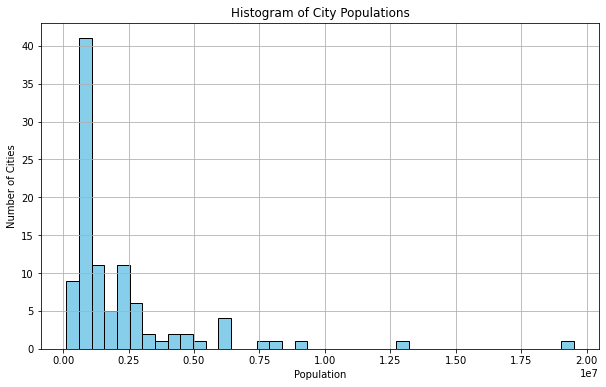

In [707]:
#now we will impute by population.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(fun['Population'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of City Populations')
plt.xlabel('Population')
plt.ylabel('Number of Cities')
plt.grid(True)
plt.show()


In [708]:
fun['Population'].describe()

count    1.000000e+02
mean     2.188004e+06
std      2.743091e+06
min      1.210540e+05
25%      7.981842e+05
50%      1.109383e+06
75%      2.435362e+06
max      1.949825e+07
Name: Population, dtype: float64

In [727]:
#Begin imputing by creating bins

pop_min = fun['Population'].min()
pop_max = fun['Population'].max()
bins = np.linspace(pop_min, pop_max, 41)

In [728]:
#assign each city to a bin
fun['pop_bin'] = pd.cut(fun['Population'], bins=bins, labels=range(1, 41), include_lowest=True)

In [729]:
#Group by bin and find bin mean

bin_means = fun.groupby('pop_bin')['Score'].mean()

In [730]:
bin_means

pop_bin
1     30.000000
2     35.957778
3     38.779091
4     38.860000
        ...    
37          NaN
38          NaN
39          NaN
40    51.600000
Name: Score, Length: 40, dtype: float64

In [732]:
#function to impute missing values
def impute_fun(row):
    if pd.isna(row['Score']):
        return bin_means.loc[row['pop_bin']]
    else:
        return row['Score']
    
fun['fun_score'] = fun.apply(impute_fun, axis=1)

In [734]:
sum(fun['fun_score'].isnull())

0

In [735]:
#Now we can normalzie fun score


fun['fun_score_norm'] = (
    (fun['fun_score'] - fun['fun_score'].min()) /
    (fun['fun_score'].max() - fun['fun_score'].min())
) * 10

In [736]:
#slightly skewed but solid
fun['fun_score_norm'].describe()

count    100.000000
mean       3.492407
std        1.655281
min        0.000000
25%        2.690259
50%        3.195396
75%        4.096747
max       10.000000
Name: fun_score_norm, dtype: float64

In [738]:
#extract what we need

fun = fun[['Area Name (long)','fun_score_norm']]

In [739]:
#merge to final
genz = genz.merge(fun, on='Area Name (long)', how='left')

In [740]:
genz

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted),fun_score_norm
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,0.000000,5.569341,4.110790,0.652169,NaN,1.982496
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,0.000000,5.703494,3.585182,1.118553,NaN,1.366058
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,0.000000,5.916568,2.640436,1.639347,NaN,1.097793
3,47260,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",Top 100 metro areas,5.422980,6.130952,5.066667,7.459472,1.088743,5.112744,5.607387,2.623991,NaN,2.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,47900,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",Top 100 metro areas,9.510323,4.310897,4.400000,10.000000,2.931778,4.497566,2.321120,4.614892,NaN,5.026636
97,33100,"Miami, FL","Miami-Fort Lauderdale-West Palm Beach, FL",Top 100 metro areas,9.510323,7.289377,6.133333,6.743253,1.730774,6.156385,1.503122,3.870766,NaN,7.058600
98,29820,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",Top 100 metro areas,9.664807,3.894231,5.066667,5.725897,0.832744,5.644929,5.607387,2.757947,NaN,10.000000
99,46520,"Urban Honolulu, HI","Urban Honolulu, HI",Top 100 metro areas,10.000000,3.736264,4.000000,8.918907,0.000000,4.932914,1.906183,2.518120,NaN,5.445205


In [741]:
#assign to correct variable
genz['Fun factor* (multi-faceted)'] = genz['fun_score_norm']

In [742]:
#Drop duplicate
genz = genz.drop(columns=['fun_score_norm'])

In [743]:
#Check missing values just in case.

missing = genz[genz['Fun factor* (multi-faceted)'].isnull()]
len(missing)

#We are good. Move on to next variable

0

In [744]:
#One last look
genz

,FIPS,Area Name (short),Area Name (long),Area Type,Tarriff Impact,Industry Diversity,City economic growth,AI growth cities,F 500 cities,Job listings growth,Cost of living - raw,Cost of living divided by salary,Fun factor* (multi-faceted)
0,12540,"Bakersfield, CA","Bakersfield, CA",Top 100 metro areas,0.000000,0.000000,7.733333,3.789428,0.000000,5.569341,4.110790,0.652169,1.982496
1,23420,"Fresno, CA","Fresno, CA",Top 100 metro areas,1.335117,3.315018,5.200000,4.605771,0.000000,5.703494,3.585182,1.118553,1.366058
2,44700,"Stockton, CA","Stockton-Lodi, CA",Top 100 metro areas,2.077915,1.515568,0.000000,0.000000,0.000000,5.916568,2.640436,1.639347,1.097793
3,47260,"Virginia Beach, VA-NC","Virginia Beach-Norfolk-Newport News, VA-NC",Top 100 metro areas,5.422980,6.130952,5.066667,7.459472,1.088743,5.112744,5.607387,2.623991,2.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,47900,"Washington, DC-VA-MD","Washington-Arlington-Alexandria, DC-VA-MD-WV",Top 100 metro areas,9.510323,4.310897,4.400000,10.000000,2.931778,4.497566,2.321120,4.614892,5.026636
97,33100,"Miami, FL","Miami-Fort Lauderdale-West Palm Beach, FL",Top 100 metro areas,9.510323,7.289377,6.133333,6.743253,1.730774,6.156385,1.503122,3.870766,7.058600
98,29820,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",Top 100 metro areas,9.664807,3.894231,5.066667,5.725897,0.832744,5.644929,5.607387,2.757947,10.000000
99,46520,"Urban Honolulu, HI","Urban Honolulu, HI",Top 100 metro areas,10.000000,3.736264,4.000000,8.918907,0.000000,4.932914,1.906183,2.518120,5.445205


In [745]:
missing_values = genz.isnull().sum()

In [747]:
#check all columns
pd.set_option('display.max_rows', 13)
missing_values

FIPS                                0
Area Name (short)                   0
Area Name (long)                    0
Area Type                           0
Tarriff Impact                      0
Industry Diversity                  0
City economic growth                0
AI growth cities                    0
F 500 cities                        0
Job listings growth                 0
Cost of living - raw                0
Cost of living divided by salary    0
Fun factor* (multi-faceted)         0
dtype: int64

In [748]:
genz.to_csv("genz_save.csv", index=False)